# Are some features responsibles for encoding synonymy ?

In [1]:
import sklearn

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import graphviz
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import shuffle

import gensim

from gensim.models import KeyedVectors

import nltk

from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/olivier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#get infos in wordnet
def get_wornet_synonyms_hypernyms(noun, words_filter=None):
    """Return le list of hypernyms and hyponyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        hypernyms = wn.synsets(noun)[0].hypernyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hypernyms = []
    try:
        hyponyms = wn.synsets(noun)[0].hyponyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hyponyms = []
    if words_filter:
        out = []
        for w in hypernyms + hyponyms:
            if w in words_filter:
                out.append(w)
        return out
    return hypernyms + hyponyms

def get_wornet_synonyms(noun, words_filter=None):
    """Return le list of synonyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        w = []
        for sn in wn.synsets(noun): 
            #TODO: check if the synset is a nouns synset and not verbs 
            #DONE: si on passe les mots qui sont des nomns seulemnt dans words_filter
            w.extend(sn.lemma_names())
    except:
        w = []
    w = list(set(w))
    return list(filter(lambda s: s in words_filter, w)) if words_filter else w



def similar_word2vec_words(word_vectors, noun, words_filter=None, n=10):
    """Return a list of the `n` most similar words from word2vec.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)

    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a list of similar meaning words
    :rtype: list(str)
    """
    tmp = list(list(zip(*word_vectors.similar_by_word(noun, n)))[0])
    if not words_filter:
        return tmp
    return list(filter(lambda s: s in words_filter, tmp))

def get_positive_and_negatives_synonyms_pairs(word_vectors, noun, words_filter=None, n=20):
    """Return 2 lists containing the synonyms int the first, 
    and similiars words in the second.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)
    
    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a tuple containg 2 lists: ([synonyms], [similars])
    :rtype: tuple(list(str), list(str))
    """
    synonyms = get_wornet_synonyms(noun, words_filter=words_filter)
    similars = similar_word2vec_words(word_vectors, noun, words_filter=words_filter)
    not_synonyms = list(filter(lambda s: not s in synonyms, similars))
    return synonyms, not_synonyms

#list all word2vec nouns exploitables
def is_exploitable(s):
    """not accept urls, names, patterns and weird stuffs... 
    AND is in wordnet database !!"""
    if s != s.lower():
        return False
    for c in '._+#/@':
        if c in s:
            return False
    #simple heuristic: remove all words ending with 's' to get only singular nouns
    if s[-1] == 's':
        return False
    if s.isalpha():
        return wn.synsets(s) != [] #check if is in wordnnet databse


In [3]:
try:
    positives = np.load("positives.npy")
    negatives = np.load("negatives.npy")
except:
    print("* load word2vec pretrained from google")
    word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

    print("* load nouns")

    print(" - list all wordnet nouns")
    wordnet_nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

    print(" - build a list of exploitable words")
    words = list(filter(is_exploitable, word_vectors.index2word))
    words = list(filter(lambda s: s in wordnet_nouns, words))

    #example
    synonyms, not_synonyms = get_positive_and_negatives_synonyms_pairs(word_vectors, "dog", words)

    print("* build a dataset of synonyms / not synonyms")
    positives = []
    negatives = []

    allready_seen_words = [] #allow us to remove some simple duplicates

    shuffle(words)

    nb_max_words = len(words)

    print(" - build pairs")
    for word in tqdm(words[:nb_max_words]):
        if word in allready_seen_words:
            continue
        allready_seen_words.append(word)
        pos, neg = get_positive_and_negatives_synonyms_pairs(word_vectors, word, words)
        for p in pos:
            positives.append((word, p))
        for n in neg:
            negatives.append((word, n))

    np.save("positives", np.array(positives))
    np.save("negatives", np.array(negatives))

positives = list(positives)
negatives = list(negatives)

shuffle(positives)
shuffle(negatives)

positives = np.array(positives)
negatives = np.array(negatives)

In [4]:
positives, negatives

(array([['depository', 'deposit'],
        ['first', 'beginning'],
        ['dispersion', 'scattering'],
        ...,
        ['eddy', 'purl'],
        ['patch', 'while'],
        ['running', 'draw']], dtype='<U31'), array([['bolete', 'chanterelle'],
        ['aura', 'cachet'],
        ['griffon', 'borzoi'],
        ...,
        ['place', 'finish'],
        ['adelaide', 'sydney'],
        ['transcendence', 'profundity']], dtype='<U29'))

In [5]:
try:
    positive_embedings = np.load("positive_embedings.npy")
    negative_embedings = np.load("negative_embedings.npy")
except:
    print(" - compute embedings")
    positive_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        positives
    )))

    negative_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        negatives
    )))
    
    np.save("positive_embedings", positive_embedings)
    np.save("negative_embedings", negative_embedings)

positive_embedings = list(positive_embedings)
negative_embedings = list(negative_embedings)

shuffle(positive_embedings)
shuffle(negative_embedings)

positive_embedings = np.array(positive_embedings)
negative_embedings = np.array(negative_embedings)

In [6]:
#keep the same number of positive vs negatives
nb_max_rows = min(len(positives), len(negatives))

positive_train = positive_embedings[:int(nb_max_rows * .8)]
positive_test  = positive_embedings[int(nb_max_rows * .8):nb_max_rows]

negative_train = negative_embedings[:int(nb_max_rows * .8)]
negative_test  = negative_embedings[int(nb_max_rows * .8):nb_max_rows]

In [7]:
print(" - split dataset in training/test sets")
x_train = np.array(list(positive_train) + list(negative_train))
y_train = np.array([0] * len(positive_train) + [1] * len(negative_train)) #0 means synonym

x_test = np.array(list(positive_test) + list(negative_test))
y_test = np.array([0] * len(positive_test) + [1] * len(negative_test))

 - split dataset in training/test sets


In [8]:
print(" - augment the dataset by adding the symetry")
#adding a symetry to the dataset let us to augment data for free 
#and remove some noise (the anchor words is not allways on the same side...)
build_symetry = lambda x_set : np.array([x_set[:, 0, :], x_set[:, 1, :]]).swapaxes(0, 1)

assert (build_symetry(build_symetry(x_train)) == x_train).mean() == 1. #check the axis stuff

x_train = np.array(list(x_train) + list(build_symetry(x_train)))
x_test  = np.array(list(x_test)  + list(build_symetry(x_test)))

y_train = np.array(list(y_train) + list(y_train))
y_test  = np.array(list(y_test)  + list(y_test))

 - augment the dataset by adding the symetry


In [9]:
print(" - blip bloup")
"""
#we need to concat the 2 embedings into a same vector to pass it to the classifier
x_train = np.array(list(map(lambda c: list(c[0]) + list(c[1]), x_train)))
x_test  = np.array(list(map(lambda c: list(c[0]) + list(c[1]), x_test)))
"""
#substract w1 - w2 to get a difference of words to find if there is a dimension which encode synonymy
x_train = x_train[:, 0, :] - x_train[:, 1, :]
x_test  = x_test[:, 0, :]  - x_test[:, 1, :]


 - blip bloup


In [10]:
print(" - shuffle data")
data_train = list(zip(x_train, y_train))
data_test  = list(zip(x_test,  y_test))

shuffle(data_train)
shuffle(data_test)

x_train, y_train = list(zip(*data_train))
x_test,  y_test  = list(zip(*data_test))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

 - shuffle data


## Train models and look what they learnt

linear model
synonyms calssification accyracy :  66.63412252867951  %
[150 288 126 121 198 233 298 199  87 149  74 170 178  61  63 290 226 208
 254  55  59 118 277  85  73  94 231  51 217 289   6 209  93 195 139 237
 299 272 251 253 162 146 164 265 186  17 236 104 161  39 292 131 184 166
 257 174 163 180 225 262 282 287 229 105 263 190  45 245 286 102 250 215
  72 297 123  77 165 256  25 247 293 241 107  86  40 295 141  18 151 144
 147 157 270 169  32  12 188 284  27 280 194 268 266 206  35  84 193  68
 275  50 274  66  19 128 200 176 203  98 127 179  10 148 285 153 112  23
  76 108 235 103 173  92  75   3 191 106 260 197  79   8 213  97  56 212
 116 119 243  96 192 291 132 221 177 185 246 204 159  43 130 120 228   7
 223 234  33 210 264 281 283  20   5 216 227 122  14 171 101   1 255  60
 111  80 136  34  15  78  29 220 219 129  89 109 156 100   9  83 239  26
 152 172  99 181  88 134  52 124  22 214  49 269  53 230 175 113 135  62
 276 201 248 207 145 137  67 259  65 110  24  46 187  

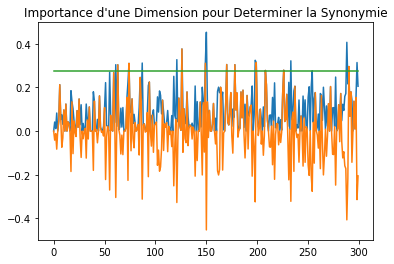

In [27]:
print("linear model")
clf = LogisticRegression(penalty='l1', C=0.05)
clf.fit(x_train, y_train)

acc = (clf.predict(x_test) == y_test).mean()
print("synonyms calssification accyracy : ", acc * 100, " %")

coefs = clf.coef_[0]

plt.title("Importance d'une Dimension pour Determiner la Synonymie")
plt.plot(abs(coefs))
plt.plot(coefs)

print(abs(coefs).argsort()[::-1])

#set a threshold
t = abs(coefs)
t = t.mean() + t.std() * 2
plt.plot([t] * len(coefs))

plt.show()

In [45]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(x_train, y_train)

acc = (dt_clf.predict(x_test) == y_test).mean()
print("synonyms calssification accyracy : ", acc * 100, " %")

synonyms calssification accyracy :  73.34635098852819  %


In [46]:
def print_decision_tree(tree, feature_names=None, offset_unit='    '):
    '''Plots textual representation of rules of a decision tree
    tree: scikit-learn representation of tree
    feature_names: list of feature names. They are set to f1,f2,f3,... if not specified
    offset_unit: a string of offset of the conditional block'''

    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    if feature_names is None:
        features  = ['f%d'%i for i in tree.tree_.feature]
    else:
        features  = [feature_names[i] for i in tree.tree_.feature]        

    def recurse(left, right, threshold, features, node, depth=0):
            offset = offset_unit*depth
            if (threshold[node] != -2):
                    print(offset+"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node],depth+1)
                    print(offset+"} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node],depth+1)
                    print(offset+"}")
            else:
                    print(offset+"return " + str(value[node]))

    recurse(left, right, threshold, features, 0,0)

print_decision_tree(dt_clf)

if ( f126 <= 0.00018310546875 ) {
    if ( f126 <= -7.62939453125e-05 ) {
        if ( f163 <= 0.2342681884765625 ) {
            return [[15232. 28336.]]
        } else {
            return [[3242. 2430.]]
        }
    } else {
        if ( f130 <= -0.015625 ) {
            return [[24. 70.]]
        } else {
            return [[29322.    40.]]
        }
    }
} else {
    if ( f61 <= 0.283050537109375 ) {
        if ( f138 <= -0.24934959411621094 ) {
            return [[2260. 2094.]]
        } else {
            return [[13344. 31038.]]
        }
    } else {
        if ( f198 <= 0.2132568359375 ) {
            return [[1644. 1390.]]
        } else {
            return [[484. 154.]]
        }
    }
}


feature	importance
126	0.9267192131585212
163	0.024399939878975773
61	0.02266466067621907
138	0.018663172689731115
130	0.005108841868688651
198	0.0024441717278641893


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


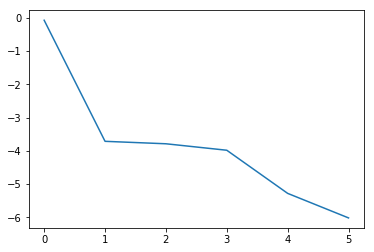

In [50]:
feature_importances = dt_clf.feature_importances_.argsort()[::-1]
print("feature\timportance")
for fi in feature_importances:
    t = dt_clf.feature_importances_[fi]
    if  t > 0:
        print(str(fi) + "\t" + str(t))
    else:
        break

plt.plot(np.log(sorted(dt_clf.feature_importances_)[::-1]))
plt.show()